In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
weight_file = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [3]:
import os

pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    weights=None,
    include_top=False
)

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
pre_trained_model.load_weights(weight_file)

In [6]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer = pre_trained_model.get_layer("mixed7")

In [9]:
last_output = last_layer.output

In [10]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
x = Flatten()(last_output)

x = Dense(1024, activation="relu")(x)

x = Dropout(0.2)(x)

x = Dense(1, activation="sigmoid")(x)

In [13]:
model = Model(pre_trained_model.input, x)

In [14]:
model.compile(loss="binary_crossentropy", optimizer=RMSprop(learning_rate=0.001), metrics=["acc"])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
train_folder = "./horse-or-human"
valid_folder = "./validation-horse-or-human"

In [17]:
batch_size = 64

In [18]:
train_generate = ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True, zoom_range=0.5)
valid_generate = ImageDataGenerator(rescale=1/255)

In [19]:
train_generator = train_generate.flow_from_directory(
    train_folder,
    target_size=(150,150),
    class_mode="binary",
    batch_size=batch_size
)
valid_generator = valid_generate.flow_from_directory(
    valid_folder,
    target_size=(150,150),
    class_mode="binary",
    batch_size=batch_size
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [20]:
len(valid_generator)

4

In [21]:
history = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    verbose=2
)

/home/tdinh/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
17/17 - 59s - loss: 3.3818 - acc: 0.8685 - val_loss: 0.0730 - val_acc: 0.9922
Epoch 2/10
17/17 - 7s - loss: 0.1963 - acc: 0.9796 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 3/10
17/17 - 7s - loss: 0.0266 - acc: 0.9932 - val_loss: 0.0437 - val_acc: 0.9922
Epoch 4/10
17/17 - 7s - loss: 0.4885 - acc: 0.9591 - val_loss: 0.0153 - val_acc: 0.9961
Epoch 5/10
17/17 - 7s - loss: 0.0366 - acc: 0.9951 - val_loss: 4.1605e-04 - val_acc: 1.0000
Epoch 6/10
17/17 - 7s - loss: 0.0946 - acc: 0.9834 - val_loss: 0.1601 - val_acc: 0.9805
Epoch 7/10
17/17 - 7s - loss: 0.0356 - acc: 0.9961 - val_loss: 0.0273 - val_acc: 0.9961
Epoch 8/10
17/17 - 7s - loss: 0.0299 - acc: 0.9971 - val_loss: 4.8450e-10 - val_acc: 1.0000
Epoch 9/10
17/17 - 7s - loss: 1.6282e-04 - acc: 1.0000 - val_loss: 9.3719e-05 - val_acc: 1.0000
Epoch 10/10
17/17 - 7s - loss: 0.0668 - acc: 0.9922 - val_loss: 3.5296e-05 - val_acc: 1.0000


In [22]:
img_test = "./download.jpeg"

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [25]:
img = image.load_img(img_test, target_size=(150,150))

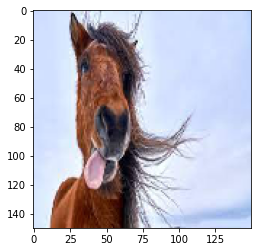

In [28]:
plt.imshow(img)

In [29]:
x = image.img_to_array(img)/255

In [31]:
x = np.expand_dims(x, axis=0)

In [32]:
images = np.vstack([x])

In [33]:
images.shape

(1, 150, 150, 3)

In [35]:
classes = model.predict(images, batch_size=10)

In [36]:
classes

array([[1.1042042e-15]], dtype=float32)